# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv <= 3.4.2`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [2]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import io
import cv2.xfeatures2d
import scipy
from copy import copy, deepcopy
from skimage.transform import ProjectiveTransform, warp

# Helper functions

In [3]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [64]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    data = []
    temp = deepcopy(dist)
    dist = np.ravel(dist)
    dist.sort() 
    keypoints = []
    for i in range(num_matches):
        k, q = np.where(temp == dist[i])
        this = []
        this.append(int(kp1[k[0]].pt[0]))
        this.append(int(kp1[k[0]].pt[1]))
        this.append(int(kp2[q[0]].pt[0]))
        this.append(int(kp2[q[0]].pt[1]))
        data.append(this)
        keypoints.append(kp2[q[0]])
    out = img2.copy()
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    out = cv2.drawKeypoints(img2, keypoints, out, 
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   
    plt.imshow(out)
    plt.axis('off')
    plt.show()
    return data

In [5]:
def compute_homography(matches):
    """
    write your code to compute homography according to the matches
    """
    A = np.zeros((8,9))
    for i in range(4):
        A[i*2,:] = [0, 0, 0, matches[i][0],matches[i][1], 1, -matches[i][3]*matches[i][0], -matches[i][3]*matches[i][1], -matches[i][3]*1]
        A[i*2+1,:] = [matches[i][0], matches[i][1], 1, 0, 0, 0, -matches[i][2]*matches[i][0], -matches[i][2]*matches[i][1], -matches[i][2]*1]
    U, S, V = np.linalg.svd(A)
    H = V[-1,:].reshape(3, 3)
    return H

In [6]:
def ransac(data):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    #select 4 random matches
    num_iter = 4000
    best_num = 0
    thres = 5
    for ite in range(num_iter):
        matches = []
        for i in range(4):
            k = np.random.randint(0,len(data))
            matches.append(data[k])
        H = compute_homography(matches)
        if np.linalg.matrix_rank(H) < 3:
            continue
        one_col = np.ones((len(data),1))
        left = np.concatenate((data[:,0:2], one_col), axis = 1)
        right = np.concatenate((data[:,2:4], one_col), axis = 1)
        inliers = []
        total_error = 0
        for i in range(len(data)):
            temp = np.matmul(H, left[i])
            temp = temp/temp[-1]
            error = np.linalg.norm(temp - right[i])**2
            if error < thres:
                list0 = np.concatenate((left[i][0:2], right[i][0:2])).tolist()
                inliers.append(list0)
                total_error += error
        if len(inliers) > best_num:
            max_inliers = inliers.copy()
            best_num = len(inliers)
            best_H = H
            best_model_errors = total_error/best_num
    return max_inliers, best_model_errors, best_H

In [33]:
def warp_images(img1, img2, H): 
    trans1 = [[0, 0], [0, len(img1)], [len(img1[0]), len(img1)], [len(img1[0]), 0]]
    trans2 = [[0, 0], [0, len(img2)], [len(img2[0]), len(img2)], [len(img2[0]), 0]] 
    transformed = skimage.transform.ProjectiveTransform(H)
    final = np.concatenate((transformed, trans1))
    x_min, y_min = min(final[:,0]),min(final[:,1])
    x_max, y_max = max(final[:,0]), max(final[:,1])
    temp = [-xmin, -ymin]   
    new_H = np.array([[1, 0, temp[0]], [0, 1, temp[1]], [0, 0, 1]]) 
    output = warp(img2, new_H.dot(H), (x_max-x_min, y_max-y_min))    
    for i in range(len(img1)):
        for j in range(len(img1[0])):
            if temp[0]+j < result.shape[1] and temp[1]+i < result.shape[0]:
                output[temp[1]+i,temp[0]+j, :] = result[t[1]+i, temp[0]+j, :] + img1[i, j, :]
    return output


# Main functions

In [9]:
# load images
img1 = imread('./data/Q1/stitch/left.jpg')
img2 = imread('./data/Q1/stitch/right.jpg')

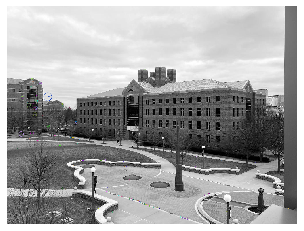

In [65]:
# part (c) compute and display the initial SIFT matching result
data = get_best_matches(img1, img2, 250)
data = np.array(data)
fig, ax = plt.subplots(figsize=(20,10))
fig.savefig('sift_match.pdf', bbox_inches='tight')

In [53]:
# part (d) performn RANSAC to get the homography and inliers, 
max_inliers, best_model_errors, best_H = ransac(data)
# display the inlier matching, report the average residual

print("Average residual:", np.average(best_model_errors))
print("Inliers:", len(max_inliers))
plot_inlier_matches(ax, img1, img2, np.asarray(max_inliers))
fig.savefig('ransac_match.pdf', bbox_inches='tight')

Average residual: 0.4358097561913586
Inliers: 15


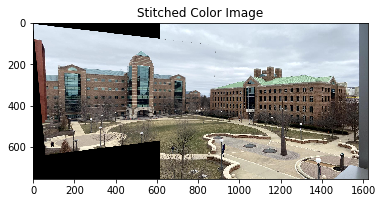

True

In [36]:
# part (e) warp images to stitch them together, 
# display and report the stitching results
output = warp_images(img2, img1, best_H)
plt.imshow(output)
plt.title('Stitched Color Image')
plt.savefig('./result/part1_stitched_colorimg.jpg')
plt.show()
cv2.imwrite('stitched_images.jpg', output[:,:,::-1]*255., 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])